# 4.0 - Probabilistic solution to a linear regression problem

<!--<badge>--><a href="https://colab.research.google.com/github/anu-ilab/JupyterPracticals/blob/main/Solutions/S4.0 - Bayesian Inference in regression-solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

In this practical, we will perform Bayesian inference for a pair of parameters, constrained by some obervational data, and examine how the posterior knowledge of the parameter changes as we collect new data.

Here we have a simple linear regression problem with intercept and gradient of a line as unknowns, and $y$ values as noisy data, $x$ values perfectly known.

As in every Python program, we need to begin by loading some libraries. For Jupyter we also need the `%matplotlib inline` command, which ensures that figures are rendered properly within the Notebook. This could be omitted if you wanted to reproduce this practical as a 'standard' Python program.



In [1]:
# -------------------------------------------------------- #
#                                                          #
#     Uncomment below to set up environment on "colab"     #
#                                                          #
# -------------------------------------------------------- #

# !pip install -U anu-inversion-course
# !git clone https://github.com/anu-ilab/JupyterPracticals
# !pip install emcee
# %cd JupyterPracticals/Solutions

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import numpy as np
import emcee
import corner

#### Set up

Here we have a set of 8 y values against x values and our task is to find a quadratic line of best data fit. 

Let us assume that the errors in the y data are independent Gaussian with a standard deviation of $\sigma = 20$.

In the next cell we specify the data, estimate best fit set of parameters with least squares and plot the best fitting curve.

 Least squares solution
 [32.20607143  9.11559524]


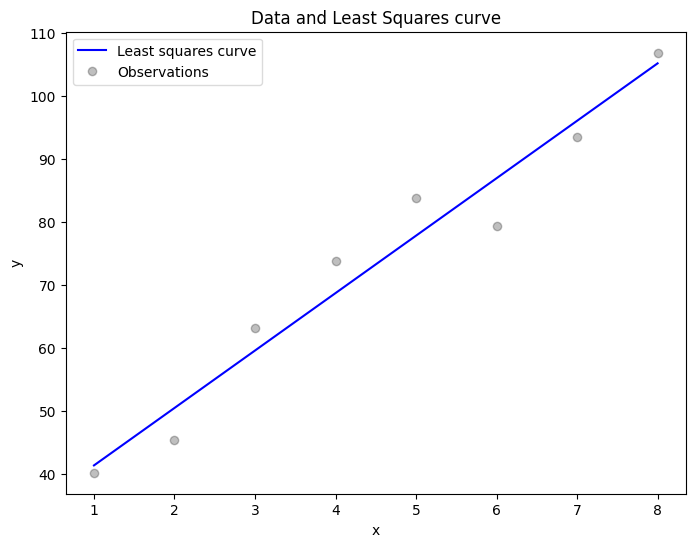

In [3]:
yobs = [ 40.16,  45.36,  63.11,  73.79,  83.83,  79.26,  93.48, 106.82] # noisy data
x = np.linspace(1.0,8.0,len(yobs))
G = np.transpose([np.ones(len(x)), x]) # G matrix

sol = np.dot(np.linalg.inv(np.dot(np.transpose(G), G)), np.dot(np.transpose(G),yobs)) # Least squares solution 
 
print(' Least squares solution\n',sol)

ypredicted = np.dot(G,sol) # predicted y values from least squares solution

# ----------------------------------------------------------------------------   
# plot data and least squares solution
# ----------------------------------------------------------------------------

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(x, ypredicted,label='Least squares curve',color='b')
ax.plot(x,yobs,'o',color=(0, 0, 0, 0.25),label='Observations')
plt.legend(loc='upper left',framealpha=0.7)
plt.title('Data and Least Squares curve')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

**Task 1:** 
Solve the problem with Bayesian Inference. 

Write a function to evaluate a prior PDF and a Likelihood function for this problem. From them calculate the posterior PDF. Note that it is always convenient to write routines to evaluate the log of these terms. You can assume that each unknown is bounded by $a_i \le m_i \le b_i$, where we choose $a_1=0$ and $b_1=20$, $a_2 = -5, b_2 = 80$.

Now lets address this problem from a Bayesian perspective. 

The data model relationship is 

$$ y_i = m_1 + m_2 x_i, \quad (i=1,\dots,8)$$

which can be written in the usual form ${\bf d} = G {\bf m}$, where $G$ is the kernel/design matrix.

We first define a prior for the two unknowns, ${\bf m}^T = (m_1,m_2)$. Lets make it a uniform PDF in the range $a_i \le m_i \le b_i$, 

$$ p({\bf m}) = \frac{1}{(b_1-a_1)(b_2-a_2)}.$$

Lets set $a_1=0$ and $b_1=20$, $a_2 = -5, b_2 = 80$.


In [4]:
# set bounds on parameter space
a,b = np.array([-5.,0]), np.array([80.,20])

In [5]:
# here is the prior evaluated for an input model 
def logprior(m,a,b):
    if((m>b).any() or (m<a).any()): return -np.inf
    return np.log(1./np.dot((b-a),(b-a)))

If the data errors are independent Gaussian with $\sigma = 20$. The Likelihood function is

$$ p({\bf d} | {\bf m}) \propto e^{-\frac{1}{2} ({\bf d} - G{\bf m})^T C_D^{-1} ({\bf d} - G{\bf m})} $$

which becomes

$$ p({\bf d} | {\bf m}) \propto e^{-\frac{1}{2} \sum_{i=1}^8 (y_i - m_1 - m_2 x_i)^2/\sigma^2} $$

Here is a Likelihood function for this case

In [6]:
# here is the Likelihood evaluated for an input model 
def loglikelihood(m,d,G,sigma):
    r = d - np.dot(G,m)
    return -0.5*np.dot(r,r/sigma**2)

The posterior PDF is the product of the Likelihood and the prior, and so the log posterior is the sum of the logs of Likelihood and prior.

In [7]:
# Here is the posterior evaluated for an input model 
def logposterior(m,d,G,sigma,a,b):
    return loglikelihood(m,d,G,sigma) + logprior(m,a,b)

**Task 2:**  Now enumerate the posterior PDF within the model space bounds and plot contours of the posterior together with the least squares solution. What shape does the posterior PDF take?


Now we plot the posterior PDF as a function of the two unknowns.

In [8]:
sigma = 20
nx, ny = (200, 200)
x = np.linspace(a[0], b[0], nx)
y = np.linspace(a[1], b[1], ny)
xv, yv = np.meshgrid(x, y)
post = np.zeros_like(xv)
for i in range(nx):
    for j in range(ny):
        m = np.array([xv[i,j],yv[i,j]])
        post[i,j] = np.exp(logposterior(m,yobs,G,sigma,a,b))
        #post[i,j] = logposterior(m,yobs,G,sigma,a,b)


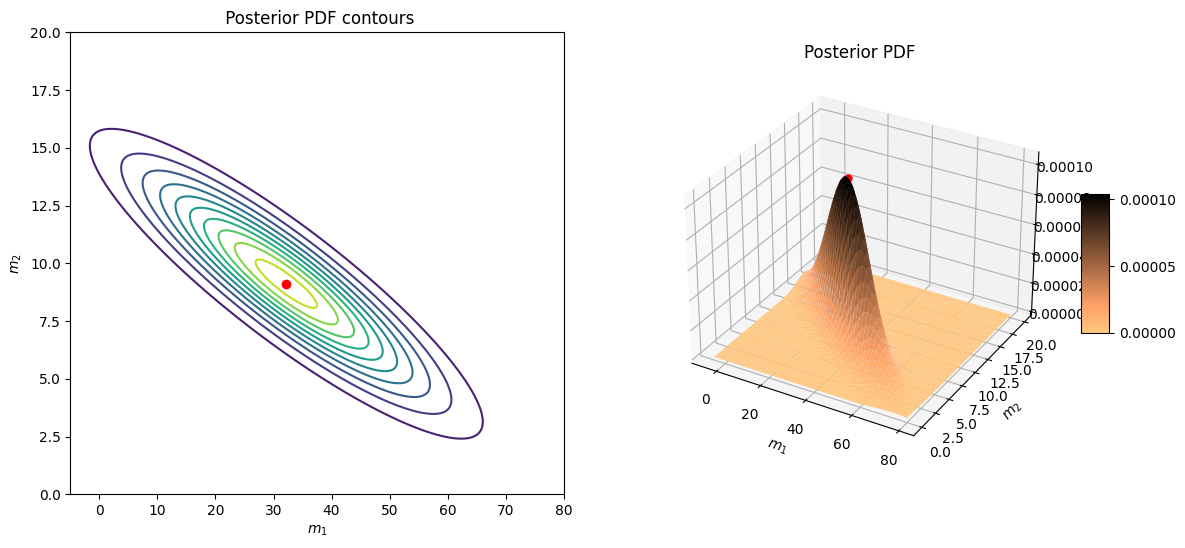

In [9]:
#fig = plt.figure(figsize=(12,6))
#fig, ax = plt.subplots(1,2, figsize=(12,6))
fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(121)

ax1.contour(xv, yv, post,10)  # plot contours of posterior PDF
ax1.plot(sol[0],sol[1],'ro') # plot least squares solution
ax1.set_title(' Posterior PDF contours')
ax1.set_xlabel('$m_1$')
ax1.set_ylabel('$m_2$')
x = np.arange(-5,5,0.1)
y = np.arange(-5,5,0.1)
ax2 = fig.add_subplot(122, projection='3d')
X,Y = np.meshgrid(x,y)
Z = X*np.exp(-X**2 - Y**2)


mycmap = plt.get_cmap('copper_r')
ax2.set_title('Posterior PDF')
ax2.set_xlabel('$m_1$')
ax2.set_ylabel('$m_2$')
surf1 = ax2.plot_surface(xv, yv, post, cmap=mycmap)
ax2.plot(sol[0],sol[1],np.max(post),'ro',markersize=5) # plot least squares solution
plt.colorbar(surf1, ax=ax2, shrink=0.3, aspect=5)

plt.show()

The red dot shows the least squares solution obtained above. Since the prior is a constant in this case we see that the posterior has the same shape as the Likelihood function, and whatsmore the Least squares solution obtained above corresponds to the maximum of the Likelihood function. Since the problem is linear and the data errors Gaussian then the posterior PDF is also a Gaussian with elliptical contours.

**Task 3:** Now using a probabilistic sampling algorithm such as `emcee` to draw random samples from teh posterior distribution and plot them with a corner plot. Calculate the mean and 95% credible intervals of each parameter from the samples.


In Bayesian Inference the posterior distribution represents the solution to the inference problem. Usually, if there are many parameters it is not possible to enumerate the entire function over the model space. Typically then one needs to draw samples from the posterior probability distribution. Here we do this with a routine that implements a general Markov chain Monte Carlo sampling, which takes as an argument the`logposterior` function.

In [10]:
# sampler the posterior PDF
pos = sol + 1e-4 * np.random.randn(32, 2)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, logposterior, args=(yobs,G,sigma,a,b)
)
sampler.run_mcmc(pos, 5000, progress=True);


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2890.05it/s]


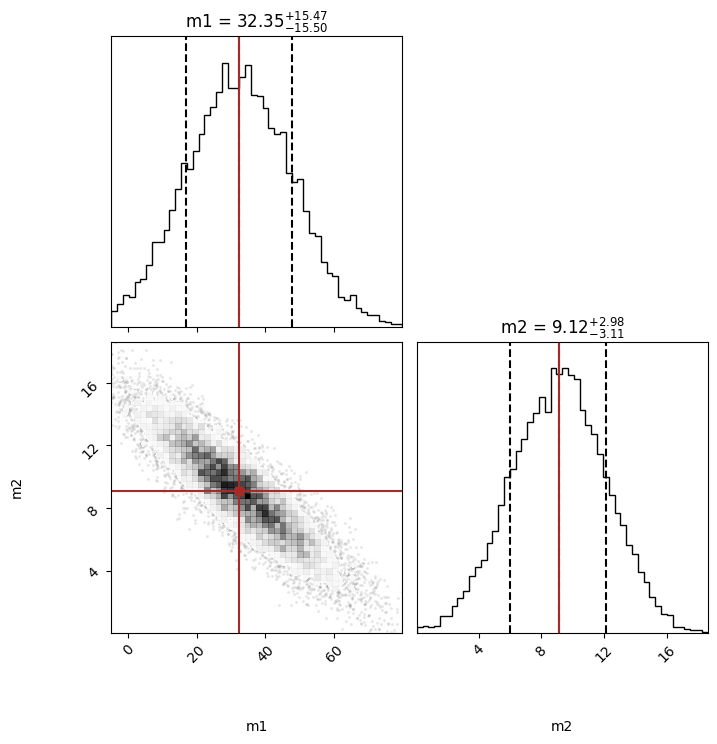

In [11]:
fig = plt.figure(figsize=(8,8))
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
figure = corner.corner(flat_samples, labels=['m1','m2','m3'],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},plot_contours=False,bins=50,truths=sol,truth_color='brown',fig=fig
)

In [12]:
# calculate percentiles
p = np.percentile(flat_samples,[2.5,97.5],axis=0) # 95% confidence intervals
p = np.percentile(flat_samples,[16,84],axis=0)    # 68% confidence intervals
ens_mean = np.mean(flat_samples,axis=0)
print(' 95% Confidence intervals: ')
print(" Parameter 1 {:7.3f} [{:7.3f}, {:7.3f}]".format(ens_mean[0],p[0,0],p[1,0]))
print(" Parameter 2 {:7.3f} [{:7.3f}, {:7.3f}]".format(ens_mean[1],p[0,1],p[1,1]))

 95% Confidence intervals: 
 Parameter 1  32.453 [ 16.850,  47.823]
 Parameter 2   9.067 [  6.014,  12.098]


In [13]:
#np.sqrt(np.diag(np.cov(flat_samples.T)))

**Task 4:** Try experimenting by defining a different prior PDF and repeating the calculations above. How much do your prior choices influence the posterior PDF? How do the mean model and credible intervals change?